In [1]:
# Load files from src
include("../src/Chebyshev.jl")
include("../src/Spheroidal.jl")
include("../src/SpectralRadialODE.jl")

import .Chebyshev as CH
import .Spheroidal as SH
import .SpectralRadialODE as RODE

# Load 3rd party packages
import Plots
import HDF5
import Polynomials: ChebyshevT
using Plots
using SpecialFunctions
using LinearAlgebra # nullspace
using GenericLinearAlgebra # for svd of bigfloat matrix
using SparseArrays

# use PyCall to load Leo's qnm code
# used in calculating the frequency and separation constant
# for overtones

# Will implement Leaver's method in julia one day
# to enable higher precision arithmetics!
using PyCall
@pyimport qnm

# Teukolsky Radial Equation

In [2]:
# input params for radial ode
# T=BigFloat required for calculating
# overtone radial functions

nr = 80;
s = -2;
l = 2;
m = 2;
n = 1;
T=BigFloat
a = T(0.5);
bhm = T(1);
nl = 20;
rmin = T(0); ## location of future null infinity (1/r = ∞)
rmax = abs(a) > 0 ? (bhm / (a^2)) * (1 - sqrt(1 - ((a / bhm)^2))) : 0.5 / bhm;

In [3]:
# Calculate frequency, separation constant, and spherical and spheroidal mixing
# only Float64 precision is supported

mode_seq = qnm.modes_cache(s=s,l=l,m=m,n=n);
omega, lambda, C = mode_seq(a=Float64(a));

In [4]:
# Construct Radial Teukolsky operator
# Then solve for the eigenfunction from the nullspace
# In the rare case where the nullspace is empty
# at the set tolerance, try increase the radial resolution
# or decrease the tolerance.

M = RODE.radial_operator(nr,s,l,m,n,a,bhm,rmin,rmax);
rs = CH.cheb_pts(rmin,rmax,nr);
null = nullspace(Matrix(M),rtol=1e-10);
radial_coef = null[:,end]
vect = CH.to_real(radial_coef);

In [5]:
D1 = CH.mat_D1(rmin,rmax,nr);

In [6]:
amp = [abs(v/vect[end]) for v in vect];
#D = CH.mat_D1(rmin,rmax,nr);

In [7]:
damp = D1*amp;

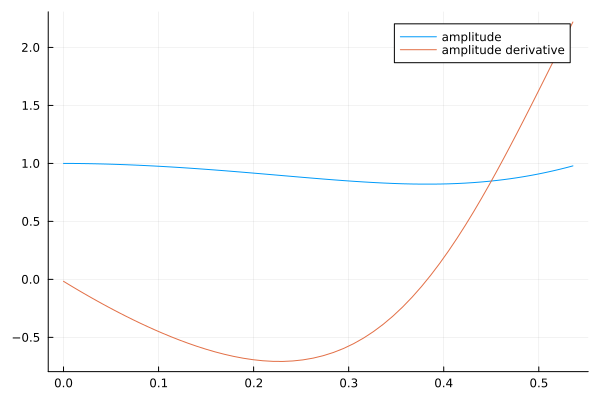

In [8]:
# Amplitude and its derivative for the overtone

Plots.plot(rs,[abs(v) for v in amp],label="amplitude")
Plots.plot!(rs,[v for v in damp],label="amplitude derivative")


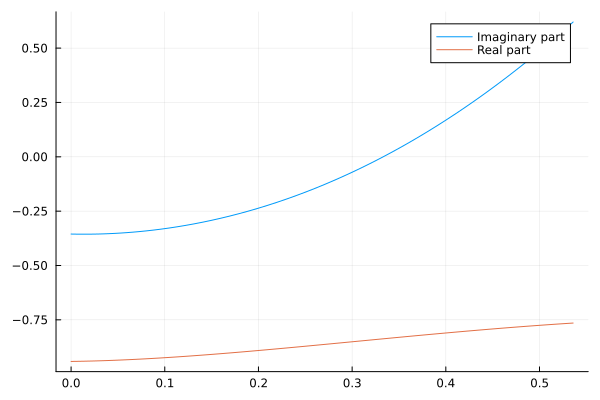

In [9]:
# Real and imaginary part of the radial eigenfunction
Plots.plot(rs,[v.im for v in vect],label="Imaginary part")
Plots.plot!(rs,[v.re for v in vect],label="Real part")
#Plots.plot!(rs,[abs(v) for v in vect],label="amplitude")


# Save the resulting files

In [10]:
function save_to_file!(
    prename::String,
    n::Integer,
    l::Integer,
    m::Integer,
    a::T,
    omega::ComplexF64,
    lambda::ComplexF64,
    C::Vector{ComplexF64},
    radial_coef::Vector{<:Complex{T}},
    vr::Vector{<:Complex{T}},
    rs::Vector{<:T},
    amp::Vector{<:T},
    damp::Vector{<:T},
) where {T<:Real}
    fname = "$(pwd())/qnmfiles/$(prename)a$(a)_l$(l)_m$(m)"
    HDF5.h5open("$fname.h5", "cw") do file
        g = HDF5.create_group(file, "[n=$(convert(Int32,n))]")
        g["nr"] = convert(Int64, length(rs))
        g["omega"] = [convert(ComplexF64, omega)]
        g["lambda"] = [convert(ComplexF64, lambda)]
        g["angular_coef"] = C
        g["radial_coef"] = [convert(ComplexF64, v) for v in radial_coef]
        g["radial_func"] = [convert(ComplexF64, v) for v in vr]
        g["rvals"] = [convert(Float64, v) for v in rs]
        g["amp"] = [convert(Float64, v) for v in amp]
        g["damp"] = [convert(Float64, v) for v in damp]
    end
    return nothing
end;

In [11]:
# Resolution for calculation and interpolation
nr = 160;
nr_interp = 300;
s = -2;
l = 2;
m = -2;
n = 7;
T=BigFloat
a = T(0.5);
bhm = T(1);

rmin = T(0); ## location of future null infinity (1/r = ∞)
rmax = abs(a) > 0 ? (bhm / (a^2)) * (1 - sqrt(1 - ((a / bhm)^2))) : 0.5 / bhm;

In [12]:
for n=0:3
    mode_seq = qnm.modes_cache(s=s,l=l,m=m,n=n);
    omega, lambda, C = mode_seq(a=Float64(a));
    M = RODE.radial_operator(nr,s,l,m,n,a,bhm,rmin,rmax);
    rs = CH.cheb_pts(rmin,rmax,nr_interp);
    radial_coef = nullspace(Matrix(M),rtol=1e-10)[:,end];
    null_interp = zeros(Complex{T},nr_interp);
    null_interp[1:nr] = radial_coef;
    vect = CH.to_real(null_interp);
    amp = [abs(v/vect[end]) for v in vect];
    println(n)
    D = CH.mat_D1(rmin,rmax,nr_interp);
    damp = D*amp;
    save_to_file!("",n,l,m,a,omega,lambda,C,radial_coef,vect,rs,amp,damp)

end


0
1
2
3
